In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps
import os
import re
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.signal import find_peaks
import pywt
import statsmodels.api as sm
from matplotlib.gridspec import GridSpec
from scipy.fft import rfft, rfftfreq

In [2]:
cm_in_inches = 1/2.54

In [3]:
def polynomial_regression(y, kernel_size, poly=4):
    kernel = np.ones(kernel_size) / kernel_size
    y_reg = np.array(np.arange(len(y))).reshape(-1,1)
    pf = PolynomialFeatures(poly)
    y_reg = pf.fit_transform(y_reg)
    reg_fit = LinearRegression().fit(y_reg, y)
    reg_predict = reg_fit.predict(y_reg)
    signal = y - reg_predict
    signal -= signal.mean()
    smoothed_signal = np.convolve(signal, kernel, mode='same')
    smoothed_signal[:int(kernel_size//2)] = np.nan
    smoothed_signal[len(smoothed_signal)-int(kernel_size//2):] = np.nan
    return smoothed_signal, signal, reg_predict

In [4]:
def plot_backscatter_full(ax1:plt.Axes, ax2:plt.Axes, data:pd.DataFrame, kernel_size:int,
                          color:str, name:str, cutoff:int, upper_threshold:int, legend_size:int, poly:int=4) -> np.ndarray:

    x = data["Time [h]"]
    x_reg = x[data["Backscatter [a.u.]"] > cutoff] - min(data["Time [h]"])
    y = data["Backscatter [a.u.]"]
    y_reg = y[data["Backscatter [a.u.]"] > cutoff]
    smooth, sig, reg = polynomial_regression(y_reg, kernel_size=kernel_size, poly=poly)

    # ax.set_ylim((200, 1200))
    ax1.set_xlim((0, upper_threshold))
    ax2.set_ylim((-18, 18))

    lns1 = ax1.plot(x, y, color=color, lw=1.5, label=name)
    lns2 = ax1.plot(x_reg, reg, color="k", ls=":", lw=1.5, label="Polynomial Regression")
 
    lns3 = ax2.plot(x_reg, sig, color=color, lw=1.5, alpha=0.4, label="Signal")
    lns4 = ax2.plot(x_reg, smooth, color="dimgrey", ls="--", lw=1.5, label="Smoothed Signal")

    # ax1.legend(loc="upper left") # , ncol=2, bbox_to_anchor=(0.13, 0.95), fontsize=8

    lns = lns1+lns2+lns3+lns4
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="upper left", fontsize=legend_size, ncol=2)


    ax1.set_xlabel("Time [h]")

    ax1.set_xticks(range(0, upper_threshold+1, 24), minor=False)
    ax1.set_xticks(range(0, upper_threshold+1, 12), minor=True)
    # ax1.tick_params(labelsize=8)
    # ax.set_yticks(range(200, 1201, 200), minor=False)
    # ax.set_yticks(range(200, 1201, 50), minor=True)
    ax2.set_yticks(range(-15, 16, 5), minor=False)
    ax2.set_yticks(range(-18, 19, 1), minor=True)

    return smooth

### Figure 1:

In [5]:
synechocystis = pd.read_excel("XLXS\\FIG2\\2021_11_03_Oszillation_Syn6803.xlsx",
                           skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
synechocystis = synechocystis[synechocystis["Time [h]"] <= 192]

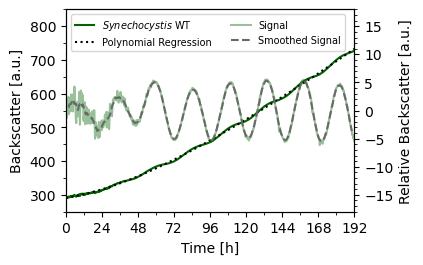

In [6]:
fig, ax = plt.subplots(figsize=(11*cm_in_inches, 7*cm_in_inches), layout="tight")
ax2 = plt.twinx(ax)
plot_backscatter_full(ax, ax2, synechocystis, kernel_size=100, color="darkgreen", name=r"$Synechocystis$ WT", cutoff=0, upper_threshold=192, legend_size=7)
ax.set_ylabel("Backscatter [a.u.]")
ax.set_ylim((250, 850))
ax.set_yticks(range(300, 801, 100), minor=False)
ax.set_yticks(range(250, 851, 50), minor=True)
ax2.set_ylabel("Relative Backscatter [a.u.]")
fig.savefig(".\\XLXS\\FIG1\\Figure1.pdf", dpi=500)
fig.savefig(".\\XLXS\\FIG1\\Figure1.png", dpi=500)

### Figure 2:

In [7]:
def plot_backscatter(ax:plt.Axes, data:pd.DataFrame, kernel_size:int, color:str, name:str, cutoff:int, poly:int=4) -> np.ndarray:
    x = data["Time [h]"][data["Backscatter [a.u.]"] > cutoff]
    y = data["Backscatter [a.u.]"][data["Backscatter [a.u.]"] > cutoff]
    smooth, sig, reg = polynomial_regression(y, kernel_size=kernel_size, poly=poly)

    # ax1.set_ylim((200, 1200))
    ax.set_xlim((0, 192))
    ax.set_ylim((-18, 18))

    # ax1.plot(data["Time [h]"], data["Backscatter [a.u.]"], color=color, lw=1, label=name)
    # ax1.plot(x, reg, color="k", ls="-.", lw=1, label="Polynomial Regression")
 
    # ax2.plot(x, sig, color=color, lw=1, alpha=0.4, label="Signal")
    ax.plot(x, smooth, color=color, ls="-", lw=1, label=name)
    print(np.max(smooth[~np.isnan(smooth)]))

    # ax.legend(loc="upper left", fontsize=8) # , ncol=2, bbox_to_anchor=(0.13, 0.95)
    ax.set_title(name, fontsize=10)


    ax.set_xlabel("Time [h]")

    ax.set_xticks(range(0, 192, 24), minor=False)
    ax.set_xticks(range(0, 192, 12), minor=True)
    ax.tick_params(labelsize=8)
    # ax.set_yticks(range(200, 1201, 200), minor=False)
    # ax.set_yticks(range(200, 1201, 50), minor=True)
    ax.set_yticks(range(-15, 16, 5), minor=False)
    ax.set_yticks(range(-18, 19, 1), minor=True)

    return smooth

In [8]:
def wavelet(fig:plt.Figure, ax:plt.Axes, time:np.ndarray, signal:np.ndarray, scales:np.ndarray, waveletname:str = 'cmor', 
                 cmap = colormaps.get_cmap('Dark2'), title:str = '', ylabel:str = '', xlabel:str = '') -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    dt = time[1] - time[0]
    max_time = int(time[-1]) # -100
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1./frequencies  
    
    num_lev = 128
    contourlevels = np.log2(np.linspace(224, 5000, num_lev + 1)) 
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both', cmap='plasma')

    # cbar_ax = fig.add_axes([1, 0.5, 0.03, 0.25])
    kwargs = {'format': '%.1f'}
    cbar = fig.colorbar(im, ax=ax, orientation="horizontal", location="top", **kwargs)
    

    cbar.ax.tick_params(labelsize=7, labelrotation=90)
    # ax.set_title(title, fontsize=22)
    # ax.set_ylabel(ylabel, fontsize=10)
    ax.set_xlabel(xlabel, fontsize=10)
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels([int(tick) for tick in yticks])
    ax.set_xticks(range(0, max_time, 24), minor=False)
    ax.set_xticks(range(0, max_time, 12), minor=True)

    ax.tick_params(labelsize=8)
    
    return time, period, power

In [9]:
selongatus = pd.read_excel("XLXS\\FIG2\\2021_11_03_Oszillation_Selongatus7942.xlsx",
                           skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
selongatus = selongatus[selongatus["Time [h]"] <= 192]
sampling = pd.read_excel("XLXS\\FIG2\\220228_Oszi_Syn6803_20Uhr Medium shift_sample.xlsx",
                           skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
sampling = sampling[sampling["Time [h]"] <= 192]

In [10]:
def plot_wavelet(fig, ax:plt.Axes, signal:np.ndarray):
    title = 'Wavelet Transform (Power Spectrum) of signal'
    ylabel = 'Period [h]'
    xlabel = 'Time [h]'

    N = signal[~np.isnan(signal)].shape[0]
    t0 = 0
    dt = (0.016666666666666666) # 1min = 1/60 h
    time = np.arange(0, 2 * N, 2) * dt + t0
    scales = [20, 25, 50, 60, 70, 80, 90,100, 150, 200, 250, 300, 350, 400,
            450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 
            3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]

#     scales = np.arange(1, 1000, 10)

    time, period, power = wavelet(fig, ax, time, signal[~np.isnan(signal)], scales, xlabel=xlabel, ylabel=ylabel, title=title)
    return time, period, power

In [11]:
def background_spectrum(alpha, N, period):
    p_lst = []
    dt = 2*(0.016666666666666666) # 1min = 1/60 h
    time = np.arange(0, N, 2) * dt

    for k in period:
        # power spectrum of x(n) = alpha * x(n-1) + z(n), alpha: lag-1 autocorrelation, z(n): guassian white noise
        p_k = (1 - np.power(alpha, 2))/(1 + np.power(alpha, 2) - 2 * alpha * np.cos((2*np.pi*dt/k))) 
        p_lst.append(p_k)
    return np.array(p_lst)

In [12]:
def stats(ax:plt.Axes, signal:np.ndarray, power:np.ndarray, period:np.ndarray, color=str) -> None:
    signal = signal[~np.isnan(signal)]
    N = signal.shape[0]
    normalization_factor = np.var(signal)

    mean_spectrum = []
    window_size = 1500
    power_array = np.array(power)

    for i in range(power_array.shape[0]):
        df = pd.DataFrame(data=power_array[i,:]).rolling(window=window_size)
        mean_spectrum.extend((df.mean().dropna()).mean())

    df = pd.DataFrame(data=signal)
    window_size = 700
    rolling_autocorr = df.rolling(window_size).apply(lambda x: sm.tsa.acf(x, nlags=2, fft=False)[1], raw=True)
    alpha = (rolling_autocorr.dropna()).mean()

    BPS = background_spectrum(alpha, N, period) # Background Power Spectrum

    _95th_percentile_value = 5.99

    ax.plot(period, 0.5 * _95th_percentile_value * BPS, color="r", ls="--")
    ax.plot(period, mean_spectrum/normalization_factor, '.', color=color)
    # print(mean_spectrum/normalization_factor)
    ax.set_xticks([6, 10, 15, 20, 22, 24, 26, 30, 35, 40, 45, 50, 55, 60])
    ax.tick_params(axis="x", labelrotation=90, labelsize=6)
    ax.set_ylim(0,600)
    ax.set_xlim(6,60)
    ax.invert_xaxis()
    # ax.title("Average vs. Null Hypothesis (expected background)", fontsize=20)
    ax.set_xlabel("Period [h]", fontsize=10)
    
    ax.tick_params(axis="y", labelsize=8)
    ax.legend(['95 % confidence interval', 'wavelet transform data'], fontsize=6)
    # plt.savefig('211025_6803_Average vs. Null Hypothesis.png', dpi=300)


In [13]:
def figure_1(figsize:tuple[int, int], save:bool=False) -> None:
    fig, ((ax1, ax2, ax3),
          (ax4, ax5, ax6),
          (ax7, ax8, ax9)) = plt.subplots(nrows=3, ncols=3, figsize=figsize, layout="constrained", sharex="row", sharey="row")


    signal1 = plot_backscatter(ax1, synechocystis, kernel_size=100, color="darkgreen", name=r"$Synechocystis$ WT", cutoff=0)
    ax1.set_ylabel("Relative\nBackscatter [a.u.]")
    signal2 = plot_backscatter(ax2, selongatus, kernel_size=100, color="steelblue", name=r"$Synechococcus$ WT", cutoff=0)
    signal3 = plot_backscatter(ax3, sampling, kernel_size=100, color="darkgreen", name="$Synechocystis$ WT\nwith sampling", cutoff=0, poly=4)
    
    time1, period1, power1 = plot_wavelet(fig, ax4, signal1)
#     print(time1, period1, power1)
    ax4.set_ylabel("Period [h]", fontsize=10)
    time2, period2, power2 = plot_wavelet(fig, ax5, signal2)
    time3, period3, power3 = plot_wavelet(fig, ax6, signal3)
    # ax7.tick_params(labelsize=8)
    # ax8.tick_params(labelsize=8)
    # ax9.tick_params(labelsize=8)


    stats(ax7, signal1, power1, period1, color="darkgreen")
    ax7.set_ylabel("Normalized\nPower Spectrum", fontsize=10)
    stats(ax8, signal2, power2, period2, color="steelblue")
    stats(ax9, signal3, power3, period3, color="darkgreen")



    if save:
        fig.savefig(".\\XLXS\\FIG2\\Figure2_new.pdf", dpi=500)
        fig.savefig(".\\XLXS\\FIG2\\Figure2_new.png", dpi=500)
    return None

5.291798814238382
12.48675223215647
20.27245687351757


c:\Users\Florian\anaconda3\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
c:\Users\Florian\anaconda3\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth frequency and center frequency, respectively (example: cmor1.5-1.0).
  wavelet = DiscreteContinuousWavelet(wavelet)
c:\Users\Florian\anaconda3\Lib\site-packages\pywt\_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should takethe form cmorB-C where B and C are floats representing the bandwidth fre

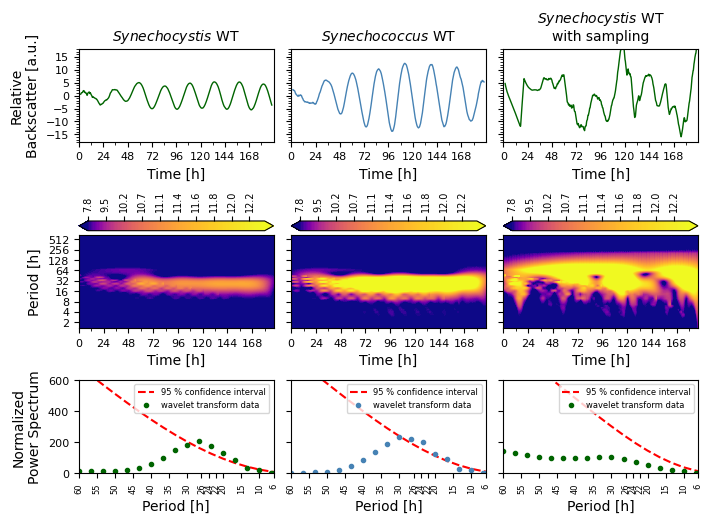

In [14]:
figure_1((17.8*cm_in_inches, 13*cm_in_inches), save=True)

### Figure 3:

In [15]:
def plot_smooth_signal(ax:plt.Axes, data:list[pd.DataFrame, pd.DataFrame, pd.DataFrame], kernel_size:int, color:tuple[str, str, str],
                       name:tuple[str, str, str], cutoff:int, upper_threshold:int, peaks:tuple[int, int, int], poly:int=4) -> None:

    x25_0 = data[0]["Time [h]"][data[0]["Backscatter [a.u.]"] > cutoff]
    x25_0 = x25_0 - x25_0.min()
    x25 = x25_0[x25_0 <= upper_threshold]
    y25 = data[0]["Backscatter [a.u.]"][data[0]["Backscatter [a.u.]"] > cutoff]
    y25 = y25[x25_0 <= upper_threshold]

    x30_0 = data[1]["Time [h]"][data[1]["Backscatter [a.u.]"] > cutoff]
    x30_0 = x30_0 - x30_0.min()
    x30 = x30_0[x30_0 <= upper_threshold]
    y30 = data[1]["Backscatter [a.u.]"][data[1]["Backscatter [a.u.]"] > cutoff]
    y30 = y30[x30_0 <= upper_threshold]

    x35_0 = data[2]["Time [h]"][data[2]["Backscatter [a.u.]"] > cutoff]
    x35_0 = x35_0 - x35_0.min()
    x35 = x35_0[x35_0 <= upper_threshold]
    y35 = data[2]["Backscatter [a.u.]"][data[2]["Backscatter [a.u.]"] > cutoff]
    y35 = y35[x35_0 <= upper_threshold]

    smooth25, sig25, reg25 = polynomial_regression(y25, kernel_size=kernel_size, poly=poly)
    smooth30, sig30, reg30 = polynomial_regression(y30, kernel_size=kernel_size, poly=poly)
    smooth35, sig35, reg35 = polynomial_regression(y35, kernel_size=kernel_size, poly=poly)


    peaks25 = find_peaks(smooth25[~np.isnan(smooth25)], distance=300, width=100, height=0.6)
    peak_t_25 = x25[peaks25[0][peaks[0]] + int(kernel_size//2)]

    peaks30 = find_peaks(smooth30[~np.isnan(smooth30)], distance=300, width=100, height=0.6)
    peak_t_30 = x30[peaks30[0][peaks[1]] + int(kernel_size//2)]

    peaks35 = find_peaks(smooth35[~np.isnan(smooth35)], distance=300, width=100, height=0.6)
    peak_t_35 = x35[peaks35[0][peaks[2]] + int(kernel_size//2)]

    x25 = x25 - peak_t_25
    x30 = x30 - peak_t_30
    x35 = x35 - peak_t_35

    ax.set_xlim((-48, upper_threshold-48)) # -48
    ax.set_ylim((-18, 18))

    ax.plot(x25, smooth25, color=color[0], lw=1, label=name[0])
    ax.plot(x30, smooth30, color=color[1], lw=1, label=name[1])
    ax.plot(x35, smooth35, color=color[2], lw=1, label=name[2])

    ax.vlines(0, -18, 18, color="k", alpha=0.3, ls="--")

    ax.legend(loc="lower left", ncol=1) # , bbox_to_anchor=(0.13, 0.95)

    ax.set_ylabel("Relative Backscatter [a.u.]")
    # ax.set_xlabel("Time from First Peak [h]")

    ax.set_xticks(range(-48, upper_threshold-47, 24), minor=False) # -47
    ax.set_xticks(range(-48, upper_threshold-47, 12), minor=True) # -47
    ax.set_yticks(range(-15, 16, 5), minor=False)
    ax.set_yticks(range(-18, 19, 1), minor=True)

    return smooth25, smooth30, smooth35

In [16]:
def fourier_transform(ax:plt.Axes, data:np.ndarray, measurement_interval_s:int, height:float, color:str, peak:int, zero_padding:int) -> None:

    # zero padding of the sample to increase frequency resolution
    sample = np.append(data[~np.isnan(data)], np.repeat(0, len(data[~np.isnan(data)])*zero_padding))

    # sample frequency:
    T = measurement_interval_s/3600

    # number of measurements (including zero padding):
    N = sample.shape[0]

    # fast furier transform:
    yf = rfft(sample)

    # frequency spectrum of the transform:
    xf = rfftfreq(N, T)

    # plotting the frequency spectrum:
    ax.plot(xf, 2/N * np.abs(yf), color=color)
    ax.set_xlim(0, 0.1)
    # ax.set_title("Frequency Spectrum")
    # ax.set_ylabel("Amplitude [a.u.]")
    # ax.set_xlabel("Frequency [1/h]")

    # determinig the highest peak of the spectrum and calculating the period:
    index = find_peaks(2/N * np.abs(yf), height=height)[0]
    period_time = 1/xf[index][peak]

    ax.text(0.98, 0.95, f"Period: {period_time:.2f} h", ha="right", va="top", transform=ax.transAxes, fontsize=9)
    return period_time

#### Synechocystis temperature data:

In [17]:
Syn_25 = pd.read_excel("XLXS\\FIG3\\2021_12_15_Oszillation_Syn6803_25C.xlsx",
                       skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
#Syn_25 = Syn_25[Syn_25["Time [h]"] <= 200]
Syn_30 = pd.read_excel("XLXS\\FIG3\\2021_11_03_Oszillation_Syn6803.xlsx",
                       skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
#Syn_30 = Syn_30[Syn_30["Time [h]"] <= 200]
Syn_35 = pd.read_excel("XLXS\\FIG3\\2021_12_29_Oszillation_Syn6803_35C.xlsx",
                       skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
#Syn_35 = Syn_35[Syn_35["Time [h]"] <= 200]

#### Synechococcus temperature data:

In [18]:
Selong_25 = pd.read_excel("XLXS\\FIG3\\2021_12_15_Oszillation_Selong7942_25C.xlsx",
                       skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
#Selong_25 = Selong_25[Selong_25["Time [h]"] <= 144]
Selong_30 = pd.read_excel("XLXS\\FIG3\\2021_11_03_Oszillation_Selongatus7942.xlsx",
                       skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
#Selong_30 = Selong_30[Selong_30["Time [h]"] <= 144]
Selong_35 = pd.read_excel("XLXS\\FIG3\\2021_12_29_Oszillation_Selong7942_35C.xlsx",
                       skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
#Selong_35 = Selong_35[Selong_35["Time [h]"] <= 144]

[[<matplotlib.lines.Line2D at 0x27201fa4210>],

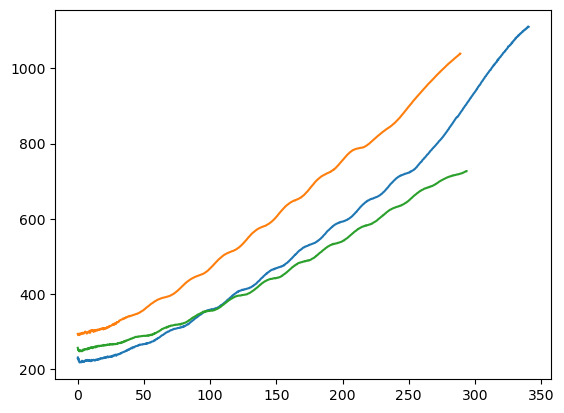

In [19]:
[plt.plot(data["Time [h]"], data["Backscatter [a.u.]"]) for data in [Syn_25, Syn_30, Syn_35]]

[[<matplotlib.lines.Line2D at 0x27202055b90>],

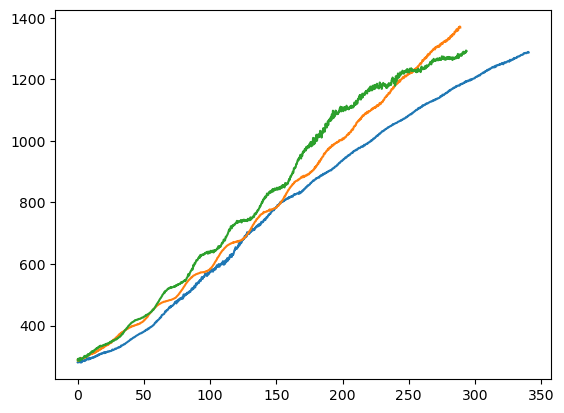

In [20]:
[plt.plot(data["Time [h]"], data["Backscatter [a.u.]"]) for data in [Selong_25, Selong_30, Selong_35]]

In [21]:
def Q10(period1:float, period2:float, temp1:int, temp2:int) -> float:
    return (period2 / period1)**(10 / (temp2 - temp1))

Q10 25/30 Synechocystis: 0.95
Q10 30/35 Synechocystis: 1.00
Q10 25/30 Synechococcus: 0.89
Q10 30/35 Synechococcus: 1.00


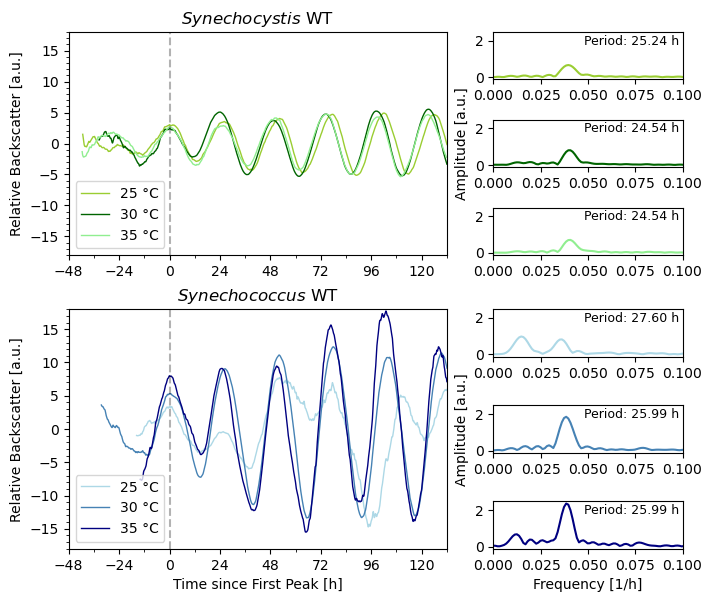

In [22]:
# fig, ((ax1, ax2),
#       (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(13, 8), layout="tight")

fig = plt.figure(layout="constrained", figsize=(17.8*cm_in_inches, 15*cm_in_inches))

gs = GridSpec(6, 6, figure=fig)
ax1 = fig.add_subplot(gs[:3, :4])
ax2 = fig.add_subplot(gs[:1, 4:])
ax3 = fig.add_subplot(gs[1:2, 4:], sharex=ax2, sharey=ax2)
ax4 = fig.add_subplot(gs[2:3, 4:], sharex=ax2, sharey=ax2)
ax5 = fig.add_subplot(gs[3:, :4], sharex=ax1, sharey=ax1)
ax6 = fig.add_subplot(gs[3:4, 4:], sharex=ax2, sharey=ax2)
ax7 = fig.add_subplot(gs[4:5, 4:], sharex=ax2, sharey=ax2)
ax8 = fig.add_subplot(gs[5:, 4:], sharex=ax2, sharey=ax2)

y_smooth25, y_smooth30, y_smooth35 = plot_smooth_signal(ax1, [Syn_25, Syn_30, Syn_35], kernel_size=100, upper_threshold=180, peaks=(0, 0, 1),
                   color=("yellowgreen", "darkgreen", "lightgreen"),
                   name=("25 °C", "30 °C", "35 °C"), cutoff=0)
o_smooth25, o_smooth30, o_smooth35 = plot_smooth_signal(ax5, [Selong_25, Selong_30, Selong_35], kernel_size=100, upper_threshold=180, peaks=(0, 0, 0),
                   color=("lightblue", "steelblue", "navy"),
                   name=("25 °C", "30 °C", "35 °C"), cutoff=0, poly=4)

y_25_period = fourier_transform(ax2, y_smooth25, 120, 0.6, color="yellowgreen", peak=0, zero_padding=4)
y_30_period = fourier_transform(ax3, y_smooth30, 120, 0.6, color="darkgreen", peak=0, zero_padding=4)
y_35_period = fourier_transform(ax4, y_smooth35, 120, 0.6, color="lightgreen", peak=0, zero_padding=4)

o_25_period = fourier_transform(ax6, o_smooth25, 120, 0.6, color="lightblue", peak=1, zero_padding=4)
o_30_period = fourier_transform(ax7, o_smooth30, 120, 0.6, color="steelblue", peak=0, zero_padding=4)
o_35_period = fourier_transform(ax8, o_smooth35, 120, 0.6, color="navy", peak=1, zero_padding=4)

Q10_y_25_30 = Q10(y_25_period, y_30_period, 25, 30)
Q10_y_30_35 = Q10(y_30_period, y_35_period, 30, 35)

Q10_o_25_30 = Q10(o_25_period, o_30_period, 25, 30)
Q10_o_30_35 = Q10(o_30_period, o_35_period, 30, 35)

print(f"Q10 25/30 Synechocystis: {Q10_y_25_30:.2f}")
print(f"Q10 30/35 Synechocystis: {Q10_y_30_35:.2f}")

print(f"Q10 25/30 Synechococcus: {Q10_o_25_30:.2f}")
print(f"Q10 30/35 Synechococcus: {Q10_o_30_35:.2f}")

ax5.set_xlabel("Time since First Peak [h]")
ax3.set_ylabel("Amplitude [a.u.]")
ax7.set_ylabel("Amplitude [a.u.]")
ax8.set_xlabel("Frequency [1/h]")

ax1.set_title("$Synechocystis$ WT")
ax5.set_title("$Synechococcus$ WT")

fig.savefig(".\\XLXS\\FIG3\\Figure3_new.pdf", dpi=500)
fig.savefig(".\\XLXS\\FIG3\\Figure3_new.png", dpi=500)

### Figure 4:

In [23]:
def plot_phase_shift(ax:plt.Axes, data:list[pd.DataFrame, pd.DataFrame], kernel_size:int, color:tuple[str, str],
                       name:tuple[str, str], cutoff:int) -> None:

    x_0h = data[0]["Time [h]"][data[0]["Backscatter [a.u.]"] > cutoff]
    x_0h = x_0h - x_0h.min()
    y_0h = data[0]["Backscatter [a.u.]"][data[0]["Backscatter [a.u.]"] > cutoff]

    x_12h = data[1]["Time [h]"][data[1]["Backscatter [a.u.]"] > cutoff]
    x_12h = x_12h - x_12h.min()
    y_12h = data[1]["Backscatter [a.u.]"][data[1]["Backscatter [a.u.]"] > cutoff]


    smooth_0h, sig_0h, reg_0h = polynomial_regression(y_0h, kernel_size=kernel_size, poly=4)
    smooth_12h, sig_12h, reg_12h = polynomial_regression(y_12h, kernel_size=kernel_size, poly=4)

    ax.set_xlim((0, 144))
    ax.set_ylim((-18, 18))

    ax.plot(x_0h, smooth_0h, color=color[0], lw=1, label=name[0])
    ax.plot(x_12h, smooth_12h, color=color[1], lw=1, label=name[1])

    ax.legend(loc="lower left", ncol=1) # , bbox_to_anchor=(0.13, 0.95)

    # ax.set_ylabel("Relative Backscatter [a.u.]")
    ax.set_xlabel("Time [h]")

    ax.set_xticks(range(0, 145, 24), minor=False)
    ax.set_xticks(range(0, 145, 12), minor=True)
    ax.set_yticks(range(-15, 16, 5), minor=False)
    ax.set_yticks(range(-18, 19, 1), minor=True)

#### dilution:

In [24]:
control_0h = pd.read_excel("XLXS\\FIG4\\2202_04_13_6803_8hr_control.xlsx",
                           skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
control_0h = control_0h[control_0h["Time [h]"] <= 144]
control_12h = pd.read_excel("XLXS\\FIG4\\2202_04_13_6803_20hr_control.xlsx",
                           skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
control_12h = control_12h[control_12h["Time [h]"] <= 144]

#### Darkshift:

In [25]:
darkshift_0h = pd.read_excel("XLXS\\FIG4\\220228_Oszi_Syn6803_8hrdarkshift.xlsx",
                           skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
darkshift_0h = darkshift_0h[darkshift_0h["Time [h]"] <= 144]
darkshift_12h = pd.read_excel("XLXS\\FIG4\\220228_Oszi_Syn6803_20hrdarkshift.xlsx",
                           skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
darkshift_12h = darkshift_12h[darkshift_12h["Time [h]"] <= 144]

[[<matplotlib.lines.Line2D at 0x27202001910>],

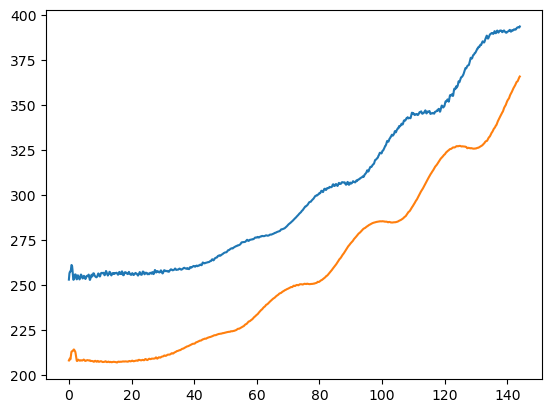

In [26]:
[plt.plot(data["Time [h]"], data["Backscatter [a.u.]"]) for data in [control_0h, control_12h]]

[[<matplotlib.lines.Line2D at 0x27202190450>],

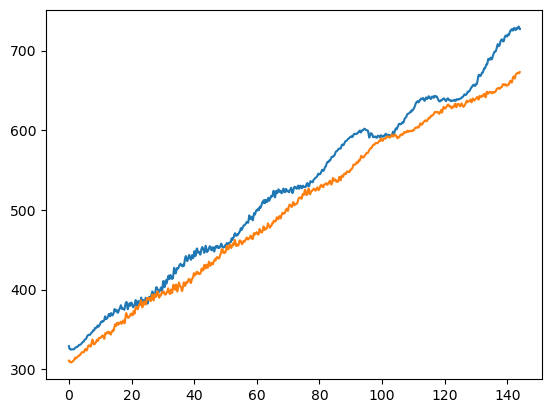

In [27]:
[plt.plot(data["Time [h]"], data["Backscatter [a.u.]"]) for data in [darkshift_0h, darkshift_12h]]

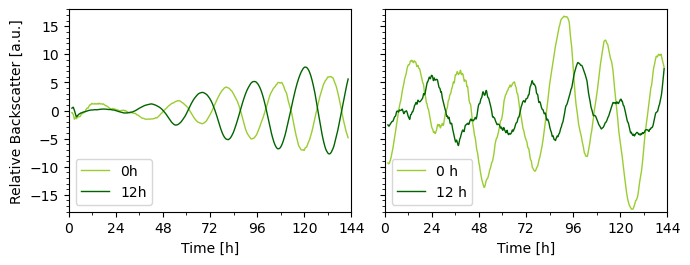

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17.8*cm_in_inches, 7*cm_in_inches), layout="tight", sharex=True, sharey=True)
plot_phase_shift(ax1, [control_0h, control_12h], kernel_size=100, color=("yellowgreen", "darkgreen"), name=("0h", "12h"), cutoff=0)
plot_phase_shift(ax2, [darkshift_0h, darkshift_12h], kernel_size=100, color=("yellowgreen", "darkgreen"), name=("0 h", "12 h"), cutoff=0)
ax1.set_ylabel("Relative Backscatter [a.u.]")
fig.savefig(".\\XLXS\\FIG4\\Figure4_new.pdf", dpi=500)
fig.savefig(".\\XLXS\\FIG4\\Figure4_new.png", dpi=500)

### Figure 5:

In [29]:
glgC = pd.read_excel("XLXS\\FIG5+6\\2022_06_02_Oszilation Syn. 6803 glgC.xlsx",
                     skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]
kaiABC = pd.read_excel("XLXS\\FIG5+6\\2022_06_23_Oszilation Syn. 6803 kaiABC.xlsx",
                     skiprows=range(44)).iloc[:,2:].loc[:,["Time [h]", "Backscatter [a.u.]"]]

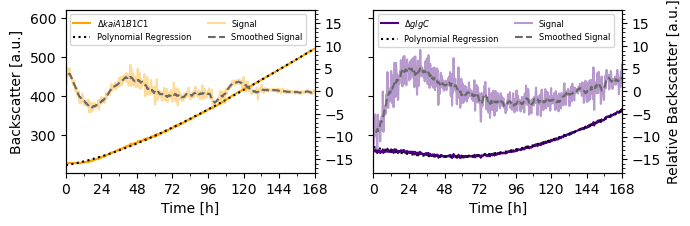

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(17.8*cm_in_inches, 6*cm_in_inches), layout="tight", sharex=True, sharey=True)
ax1_2 = plt.twinx(ax1)
ax2_2 = plt.twinx(ax2)
plot_backscatter_full(ax1, ax1_2, kaiABC, kernel_size=100, color="orange", name=r"$\Delta kaiA1B1C1$", upper_threshold=168, cutoff=0, legend_size=6, poly=4)
plot_backscatter_full(ax2, ax2_2, glgC, kernel_size=100, color="indigo", name=r"$\Delta glgC$", upper_threshold=168, cutoff=0, legend_size=6, poly=4)

ax1.set_ylabel("Backscatter [a.u.]")
ax2_2.set_ylabel("Relative Backscatter [a.u.]")

fig.savefig(".\\XLXS\\FIG5+6\\Figure5_new.pdf", dpi=500)
fig.savefig(".\\XLXS\\FIG5+6\\Figure5_new.png", dpi=500)

### Figure 7:

In [31]:
path_to_data = '.\\Publication\\220623_WTvsMutants\\2022_06_02_Oszilation Syn. 6803 glgC.xlsx'
data_glgc = pd.read_excel(path_to_data, skiprows=44)
path_to_data3 = '.\\Publication\\220623_WTvsMutants\\2022_06_23_Oszilation Syn. 6803 kaiABC.xlsx'
data_kaiABC = pd.read_excel(path_to_data3, skiprows=44)
path_to_data2 = '.\\Publication\\220623_WTvsMutants\\2021_11_03_Oszillation_Syn6803-Copy1.xlsx'
data_wt = pd.read_excel(path_to_data2, skiprows=44)

WT m: 2.98
glgC m: 1.85
a1b1c1 m: 2.20
WT td: 54.06
glgC td: 31.09
a1b1c1 td: 68.91


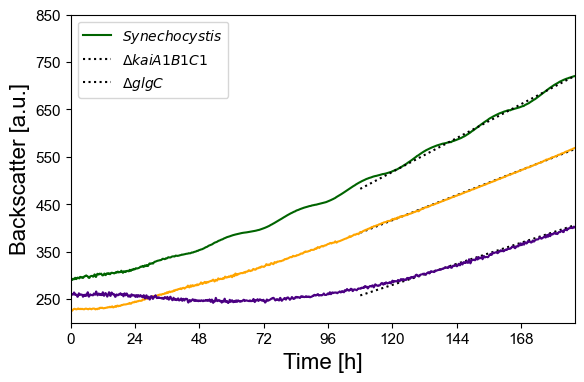

In [41]:
def poly1(x, m, b):
    return m*x + b

threshold = 108

y = data_glgc["Backscatter [a.u.]"]#-data_glgc["Backscatter [a.u.]"].min()
y2 = data_wt["Backscatter [a.u.]"]#-data_wt["Backscatter [a.u.]"].min()
x = (data_glgc['Time [h]'])# - (data1['Time [h]'].min())
x2 = (data_wt['Time [h]'])
y3 = data_kaiABC["Backscatter [a.u.]"]#-data_kaiABC["Backscatter [a.u.]"].min()
x3 = (data_kaiABC['Time [h]'])


wt_x_fit = x2[x >= threshold]
wt_y_fit = y2[x >= threshold]

glgc_x_fit = x[x >= threshold]
glgc_y_fit = y[x >= threshold]

a1b1c1_x_fit = x3[x >= threshold]
a1b1c1_y_fit = y3[x >= threshold]


wt_fit = np.polyfit(wt_x_fit , wt_y_fit, deg=1)
glgc_fit = np.polyfit(glgc_x_fit, glgc_y_fit, deg=1)
a1b1c1_fit = np.polyfit(a1b1c1_x_fit, a1b1c1_y_fit, deg=1)

wt_td = wt_fit[1]/wt_fit[0]
glgc_td = glgc_fit[1]/glgc_fit[0]
a1b1c1_td = a1b1c1_fit[1]/a1b1c1_fit[0]

print(f"WT m: {wt_fit[0]:.2f}\nglgC m: {glgc_fit[0]:.2f}\na1b1c1 m: {a1b1c1_fit[0]:.2f}")
# print(f"WT b: {wt_fit[1]:.2f}\nglgC b: {glgc_fit[1]:.2f}\na1b1c1 b: {a1b1c1_fit[1]:.2f}")
print(f"WT td: {wt_td:.2f}\nglgC td: {glgc_td:.2f}\na1b1c1 td: {a1b1c1_td:.2f}")

fig, ax = plt.subplots(figsize=(6.5,4))

plt.plot(x2, y2, color='darkgreen')
plt.plot(wt_x_fit, poly1(wt_x_fit, *wt_fit), color="k", ls=":")
plt.plot(glgc_x_fit, poly1(glgc_x_fit, *glgc_fit), color="k", ls=":")
plt.plot(a1b1c1_x_fit, poly1(a1b1c1_x_fit, *a1b1c1_fit), color="k", ls=":")
plt.plot(x3, y3, color='orange')
plt.plot(x, y, color='indigo')
#plt.title('Synechocystis sp. PCC 6803 delta glgC', fontsize=20)
plt.ylabel("Backscatter [a.u.]",fontname="Arial", fontsize=16)
plt.xlabel('Time [h]', fontname="Arial",fontsize=16)

plt.xticks(np.arange(min(x), max(x)+1, 24), fontname="Arial",  fontsize=11)
plt.yticks(np.arange(min(y2)-40.2, max(y2)+1, 100), fontname="Arial",  fontsize=11)
plt.legend(['$Synechocystis$','\u0394$kaiA1B1C1$',  '\u0394$glgC$'])
plt.xlim(0,188)
plt.ylim(200,850)
plt.savefig('wtVSmutants.png', bbox_inches='tight' , dpi=300)
plt.savefig('wtVSmutants.svg', bbox_inches='tight' , dpi=300)
plt.show()
ylist = list(y)
greaterthan330 = next(x for x, val in enumerate(ylist)
                                  if val > 230)
xlist = list(x)
type(xlist)
lowerthan225 = next(x for x, val in enumerate(xlist)
                                  if val > 225)

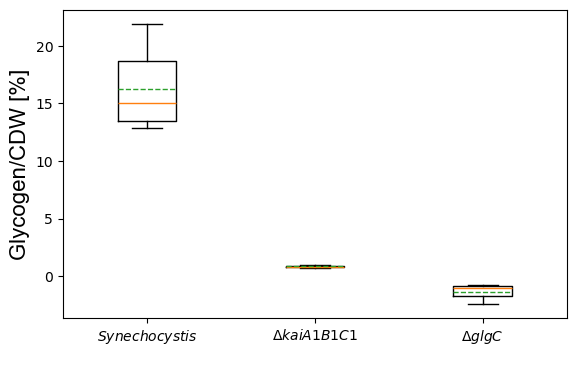

Glycogen Content [% Dryweight] 6803 wt: 16.26812320666667
Glycogen Content [% Dryweight] 6803 Δ$glgC$: -1.3797424169999999
Glycogen Content [% Dryweight] 6803 Δ$kaiA1B1C1$: 0.856868933


In [50]:
glgc = [-2.379592608,-1.037258316,-0.722376327]
kai = [0.842772382,0.749131006,0.978703411]
wt = [21.91208193,13.42909435,13.60060258,19.38376478,16.45292949,12.83026611]

boxplot_list = [wt,kai,glgc]
labels = ['$Synechocystis$','\u0394$kaiA1B1C1$',  '\u0394$glgC$']
fig, ax = plt.subplots(figsize=(6.5,4))
plt.boxplot(boxplot_list, tick_labels = labels, autorange = True, meanline=True,
                   showmeans=True, widths=.35)
# plt.ylim(0,25)
plt.ylabel("Glycogen/CDW [%]",fontname="Arial", fontsize=16)
plt.xlabel(" ",fontname="Arial", fontsize=16)
plt.savefig('glycogen_Boxplot_Temp.png', bbox_inches='tight' ,  dpi=300)
plt.savefig('glycogen_Boxplot_Temp.svg', bbox_inches='tight' ,  dpi=300)
plt.show()
print('Glycogen Content [% Dryweight] 6803 wt:',np.mean(wt))
print('Glycogen Content [% Dryweight] 6803 \u0394$glgC$:',np.mean(glgc))
print('Glycogen Content [% Dryweight] 6803 \u0394$kaiA1B1C1$:',np.mean(kai))



In [35]:
filePath = ".\\Publication\\Casy\\Clock_Projekt_CASY_Daten\\"
new_files = [file for file in os.listdir(filePath) if file.endswith("newfile.txt")]
dataframes = []
for file in new_files:
    df = pd.read_table(filePath + file, header=0)
    dataframes.append(df)
dfs = [dataframes[1], dataframes[3], dataframes[0], dataframes[2], dataframes[8],
       dataframes[15], dataframes[4], dataframes[5], dataframes[6], dataframes[7],
       dataframes[9], dataframes[10], dataframes[11], dataframes[12], dataframes[13],
       dataframes[14], dataframes[16], dataframes[17], dataframes[18], dataframes[19],
       dataframes[20], dataframes[21], dataframes[22], dataframes[23], dataframes[24],
       dataframes[25], dataframes[26], dataframes[27]]

In [42]:
#boxplot Versuch
list1 = [dataframes[12]['Size Channel'][155:358]] #358 = 3.5 // 515 = 5.0 #Liste für Size channel datenbereich 1,5um-5um
list2 = [dataframes[12]['Counts'][155:358]]  # counts synechocystis

list4 = [dataframes[15]['Counts'][155:358]]  # counts synechocystis kaiABC

list6 = [dataframes[3]['Counts'][155:358]] # counts glgC

#neu Listen um die Gesamt verteilung als Boxplot darstellen zu können
syn = np.multiply(list1,list4) 
glgC = np.multiply(list1,list2)
kaiABC = np.multiply(list1,list6)

def get_data(size_list:list,count_list:list)->pd.DataFrame:
    dataset=[]
    for i,k in zip(count_list,size_list):
        dataset.extend(i * [k])
    return dataset

counts_Synechocystis = dataframes[12]['Counts'][155:358]  # counts synechocystis

counts_Synechocystis_kaiABC = dataframes[15]['Counts'][155:358]  # counts synechocystis kaiABC

counts_Synechocystis_glgC = dataframes[3]['Counts'][155:358] # counts glgC

WT= 6,9,12,18,7,10,14,19
kaiabc = 0,2,8,15
glgc =1,3

size_Synechocystis = dataframes[12]['Size Channel'][155:358]  #Liste für Size channel datenbereich 1,5um-5um
counts_Synechocystis = dataframes[12]['Counts'][155:358]  # counts synechocystis

counts_Synechocystis_kaiABC = dataframes[15]['Counts'][155:358]  # counts synechocystis kaiABC

counts_Synechocystis_glgC = dataframes[3]['Counts'][155:358] # counts glgC

df_Synechocystis=get_data(size_Synechocystis,counts_Synechocystis)
df_Synechocystis_kaiABC=get_data(size_Synechocystis,counts_Synechocystis_kaiABC)
df_Synechocystis_glgC=get_data(size_Synechocystis,counts_Synechocystis_glgC)
data=[df_Synechocystis,df_Synechocystis_kaiABC,df_Synechocystis_glgC]

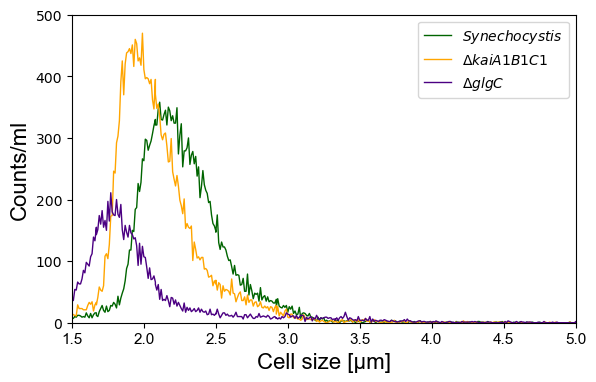

In [46]:
fig, ax = plt.subplots(figsize=(6.5,4))
#plot = plt.plot(dataframes[4]['Size Channel'][155:515],dataframes[4]['Counts'][155:515],color='lightgreen', linewidth=1)#, label="6803 wt 1.1")
#plot = plt.plot(dataframes[7]['Size Channel'][155:515],dataframes[7]['Counts'][155:515],color='limegreen', linewidth=1)#, label="6803 wt 1.2")
plot = plt.plot(dataframes[12]['Size Channel'][104:515],dataframes[12]['Counts'][104:515],color='darkgreen', linewidth=1, label="$Synechocystis$")
#plot = plt.plot(dataframes[16]['Size Channel'][155:515],dataframes[16]['Counts'][155:515],color='darkgreen', linewidth=1)#, label="6803 wt 1.4")
#plot = plt.plot(dataframes[6]['Size Channel'][155:515],dataframes[6]['Counts'][155:515],color='orange', linewidth=1)#, label="6803 \u0394kai$A_1B_1C_1$")
plot = plt.plot(dataframes[15]['Size Channel'][104:515],dataframes[15]['Counts'][104:515],color='orange', linewidth=1, label="\u0394$kaiA1B1C1$")
#plot = plt.plot(dataframes[0]['Size Channel'][155:515],dataframes[0]['Counts'][155:515],color='grey', linewidth=1, label=" \u0394glgc")
plot = plt.plot(dataframes[3]['Size Channel'][104:515],dataframes[3]['Counts'][104:515],color='indigo', linewidth=1, label="\u0394$glgC$")

plt.xticks(fontname="Arial", fontsize=11)
plt.ylabel("Counts/ml",fontname="Arial", fontsize=16)
plt.xlabel('Cell size [µm]',fontname="Arial", fontsize=16)
plt.xlim(1.5,5)
plt.ylim(0,500)
plt.legend()
#plt.savefig('Wt_kaiabc_glgC.svg', bbox_inches='tight' , dpi=300)


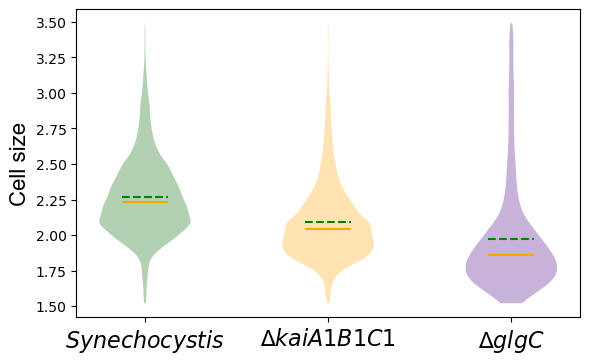

In [45]:
plt.figure(figsize=(6.5,4))
label=["$Synechocystis$","\u0394$kaiA1B1C1$","\u0394$glgC$"]
violin=plt.violinplot(data,positions=[1,2,3],showmeans = True, showextrema = False, showmedians = True) #width=.35

colors=['darkgreen','orange','indigo']
# violin color
for i,vp in enumerate(violin['bodies']):
    vp.set_facecolor(colors[i])
    #vp.set_edgecolor(colors[i])
    #vp.set_linewidth(2)
    #vp.set_alpha(0.5)
    
# violin mean max etc. color
for partname in ('cmeans','cmedians'):
    vp = violin[partname]
    if partname == 'cmedians':
        vp.set_edgecolor('orange')
        #vp.set_linewidth(1)
    elif partname == 'cmeans':
        vp.set_edgecolor('green')
        vp.set_linestyle('dashed')
    else:
        vp.set_edgecolor('black')
        vp.set_linewidth(1)
    
plt.xticks([1,2,3],label,fontname="Arial", fontsize=16)
plt.ylabel("Cell size",fontname="Arial", fontsize=16)
plt.savefig('Violinplot_CASY.svg', bbox_inches='tight' , dpi=300)

plt.show()